<h1 align="center">
  <a href="https://uptrain.ai">
    <img width="300" src="https://user-images.githubusercontent.com/108270398/214240695-4f958b76-c993-4ddd-8de6-8668f4d0da84.png" alt="uptrain">
  </a>
</h1>

<h1 style="text-align: center;">Identifying Edge cases for a Computer vision model</h1>

In this example, we consider a binary classification task of human orientation while exercising. That is, given the location of 17 key-points of the body such as the nose, shoulders, wrist, hips, ankles, etc., the model tries to predict whether the person is in a horizontal (see image 1 below) or a vertical (see image 2 below) position. 

Input: 34-dimensional vector that contains the x and y positions of the 17 key-points.\
Output: Orientation (horizontal - class 0 or vertical - class 1)

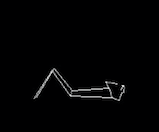
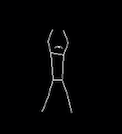

In this notebook, we will see how we can use UpTrain package to identify data drift and identify out of distribution cases on real-world data.

### Install the required packages for this example

In [1]:
#!pip install torch imgaug

In [2]:
import os
import subprocess
import zipfile
import numpy as np
import torch
import uptrain.v0 as uptrain
import time

from helper_files import read_json, KpsDataset
from helper_files import plot_all_cluster, body_length_from_kps

/Users/sourabhagrawal/miniconda3/envs/prod_merge1/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Let's first download the example dataset

In [3]:
data_dir = "data"
remote_url = "https://oodles-dev-training-data.s3.amazonaws.com/data.zip"
orig_training_file = 'data/training_data.json'
if not os.path.exists(data_dir):
    print("Starting to download example dataset...")
    try:
        # Most Linux distributions have Wget installed by default.
        # Below command is to install wget for MacOS
        wget_installed_ok = subprocess.call("brew install wget", shell=True, stdout=subprocess.DEVNULL, stderr=subprocess.STDOUT)
        print("Successfully installed wget")
    except:
        dummy = 1
    try:
        if not os.path.exists("data.zip"):
            file_downloaded_ok = subprocess.call("wget " + remote_url, shell=True, stdout=subprocess.DEVNULL, stderr=subprocess.STDOUT)
            print("Data downloaded")
        with zipfile.ZipFile("data.zip", 'r') as zip_ref:
            zip_ref.extractall("./")
        print("Prepared Example Dataset")
        os.remove("data.zip")
    except Exception as e:
        print(e)
        print("Could not load training data")
        print("Please follow following steps to manually download data")
        print("Step 1: Paste the link https://oodles-dev-training-data.s3.amazonaws.com/data.zip in your browser")
        print("Step 2: Once the zip file is downloaded, unzip it here (i.e. YOUR_LOC/uptrain/examples/1_orientation_classification/")
else:
    print("Example dataset already present")

Example dataset already present


#### Type of data files

Let's define the training and testing datasets, and visualise some of the training samples.

In [4]:
# Training data
training_file = 'data/training_data.json'

# A testing dataset to evaluate model performance
golden_testing_file = 'data/golden_testing_data.json'

# The data-points which the models sees in production
real_world_test_cases = 'data/real_world_testing_data.json'

# To annotate the collected data points, we extract the ground truth from a master annotation file 
# (we can also import from any other annotation pipelines such as an annotation job on Mechanical turk).
annotation_args = {'master_file': 'data/master_annotation_data.json'}

# Let's visualize some of the training examples
training_data = read_json(training_file, dataframe=True)
training_data.head()

,id,gt,Nose_X,Nose_Y,Left_Eye_X,Left_Eye_Y,Right_Eye_X,Right_Eye_Y,Left_Ear_X,Left_Ear_Y,...,Right_Hip_X,Right_Hip_Y,Left_Knee_X,Left_Knee_Y,Right_Knee_X,Right_Knee_Y,Left_Ankle_X,Left_Ankle_Y,Right_Ankle_X,Right_Ankle_Y
0,12002202098,1,536.832198,175.195562,275.183835,299.200492,321.438219,53.586762,438.831630,196.469141,...,355.320493,352.771307,282.603256,245.372110,-71.727270,148.854694,377.204408,118.812093,368.630415,32.683708
1,11004300163,1,127.299427,213.304615,120.006179,213.098156,119.749502,220.877945,123.240242,213.496218,...,282.739062,217.173672,331.887746,122.399542,369.934428,153.331971,407.764187,54.115847,373.738996,228.353284
2,18100208242,0,342.735809,75.173884,347.639763,69.066162,337.646757,69.463328,354.332650,70.183796,...,327.693125,175.678139,373.687116,236.403840,330.044019,238.719585,383.867725,289.895923,335.013380,292.018822
3,18100204340,0,335.262419,161.525842,340.358734,155.666068,329.570863,154.843509,347.034712,154.827196,...,316.727216,218.696415,375.741803,250.993843,285.306140,252.504808,384.364024,298.382275,275.523553,298.044853
4,12100104261,0,255.488160,62.442478,256.765451,58.603055,251.489867,58.323107,255.327531,55.634296,...,235.763698,136.902009,277.832912,177.679435,229.566259,191.052507,284.397434,213.477405,224.158806,239.154790


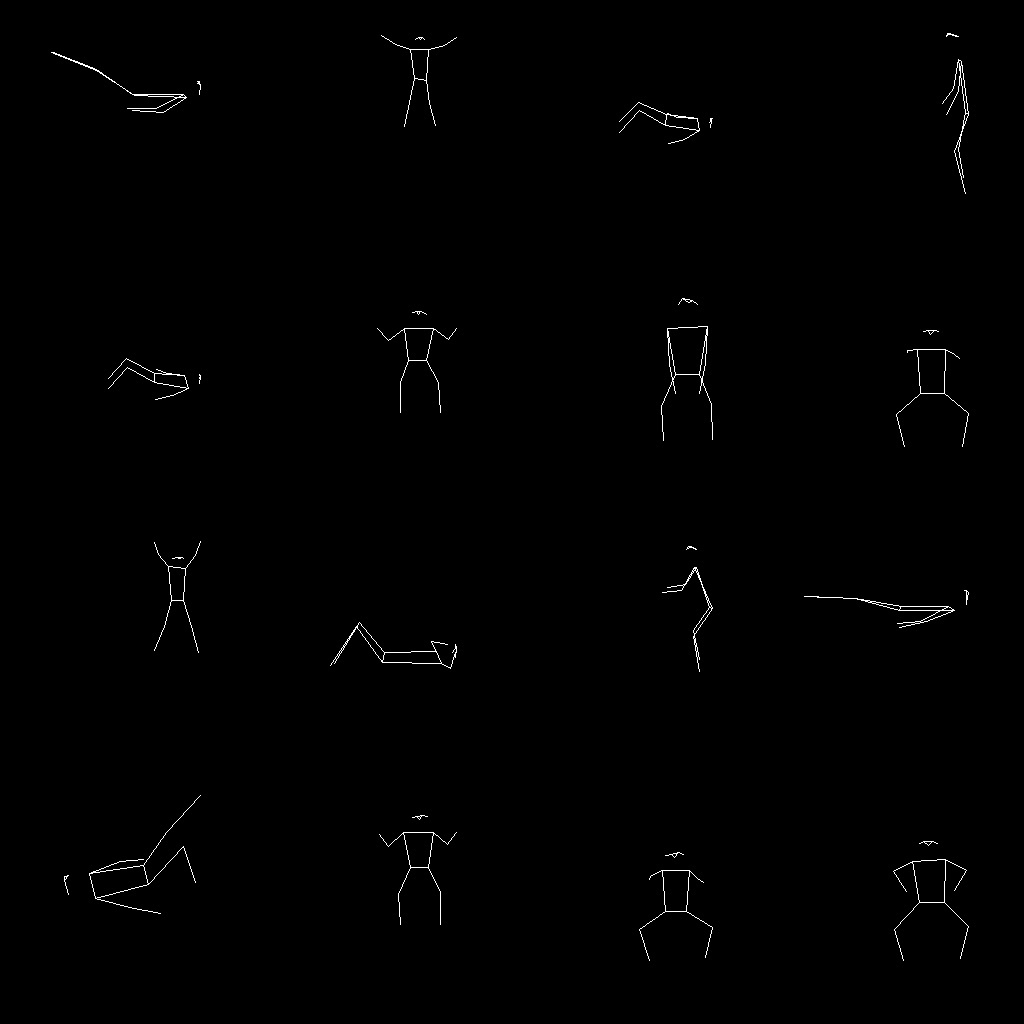

### Step 1: Train our Neural Network model

We have defined a simple Neural Net comprised of a fully-connected layer with relu activation followed by a fully-connected layer to transfer latent features into model outputs. We compute Binary Entropy loss and are using Adam optimiser to train the model

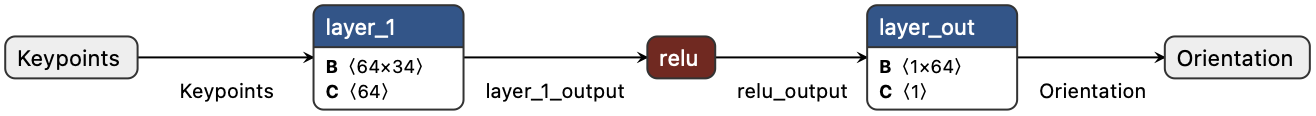



In [5]:
from helper_files import get_accuracy_torch, train_model_torch, BinaryClassification
train_model_torch(training_file, 'version_0')

Next, let's see how our model performs on the golden testing dataset

In [6]:
get_accuracy_torch(golden_testing_file, 'version_0')

Evaluating model: version_0  on  15731  data-points


0.9116394380522536

Great, we have successfully trained our Neural Network which is giving more than 90% accuracy. We will now how we can use UpTrain package to identify data distribution shifts, collect edge cases and retrain the model to improve its accuracy 

### Step 2: Define data drift check to perform on model

In this example, we define a simple data drift check to identify any distribution shift between real-world test set and the reference dataset (the training dataset in this case). To achieve this, we set 'kps' (Keypoints) as the input variable, the framework performs clustering on the training dataset and checks if the real-world test set is following the similar distribution

In [7]:
checks = [{
        'type': uptrain.Monitor.DATA_DRIFT,
        'reference_dataset': orig_training_file,
        'is_embedding': True,
        "measurable_args": {
            'type': uptrain.MeasurableType.INPUT_FEATURE,
            'feature_name': 'kps'   # keypoints
        },
    }]

print("Data Drift checks: ", checks)

Data Drift checks:  [{'type': <Monitor.DATA_DRIFT: 'data_drift'>, 'reference_dataset': 'data/training_data.json', 'is_embedding': True, 'measurable_args': {'type': <MeasurableType.INPUT_FEATURE: 'input_feature'>, 'feature_name': 'kps'}}]


### Step 3: Define the training and evaluation arguments

We now attach the model training and evaluation pipelines so that UpTrain framework can automatically retrain the model in case it sees that the model is facing significant data drift

In [8]:
# Define the training pipeline to annotate collected edge cases and retrain the model automatically
training_args = {
    "annotation_method": {"method": uptrain.AnnotationMethod.MASTER_FILE, "args": annotation_args}, 
    "training_func": train_model_torch, 
    "orig_training_file": orig_training_file,
}

# Define evaluation pipeline to test retrained model against original model
evaluation_args = {
    "inference_func": get_accuracy_torch,
    "golden_testing_dataset": golden_testing_file,
}

print("Training Pipelines: ", training_args, "\n")
print("Evaluation Pipelines: ", evaluation_args)

Training Pipelines:  {'annotation_method': {'method': <AnnotationMethod.MASTER_FILE: 1>, 'args': {'master_file': 'data/master_annotation_data.json'}}, 'training_func': <function train_model_torch at 0x2a5d09f30>, 'orig_training_file': 'data/training_data.json'} 

Evaluation Pipelines:  {'inference_func': <function get_accuracy_torch at 0x2a5d09d80>, 'golden_testing_dataset': 'data/golden_testing_data.json'}


### Step 4: Initialize the UpTrain Framework

In [9]:
cfg = {
    "checks": checks, 
    "training_args": training_args,
    "evaluation_args": evaluation_args,

    # Retrain when 200 datapoints are collected in the retraining dataset
    "retrain_after": 200,
    
    # A local folder to store the retraining dataset
    "retraining_folder": "uptrain_smart_data",
    
    # A function to visualize clusters in the data
    "cluster_visualize_func": plot_all_cluster,
    
    "logging_args": {"st_logging": True},
}

# Initialize the UpTrain framework object with config 
framework = uptrain.Framework(cfg)
print("Successfully Initialized UpTrain Framework")

Deleting the folder:  uptrain_smart_data
Deleting the folder:  uptrain_logs
Successfully Initialized UpTrain Framework


### Step 5: Try out on a real-world dataset

Ship the model to production worry-free because the UpTrain tool will identify any data drifts, collect interesting data points and automatically retrain the model on them. To mimic deployment behavior, we are running the model on a 'real-world test set' and logging model inputs with UpTrain framework.

In [10]:
inference_batch_size = 16
model_dir = 'trained_models_torch/'
model_save_name = 'version_0'
real_world_dataset = KpsDataset(
    real_world_test_cases, batch_size=inference_batch_size, is_test=True
)
model = BinaryClassification()
model.load_state_dict(torch.load(model_dir + model_save_name))
model.eval()

for i,elem in enumerate(real_world_dataset):

    # Do model prediction
    inputs = {"kps": elem[0]["kps"], "id": elem[0]["id"]}
    x_test = torch.tensor(inputs["kps"]).type(torch.float)
    test_logits = model(x_test).squeeze() 
    preds = torch.round(torch.sigmoid(test_logits)).detach().numpy()

    # Log model inputs and outputs to the uptrain Framework to monitor data drift
    idens = framework.log(inputs=inputs, outputs=preds)
    time.sleep(0.01)

    # Retrain only once
    if framework.version > 1:
        break


  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://192.168.6.92:8501

  For better performance, install the Watchdog module:

  $ xcode-select --install
  $ pip install watchdog
            
50 edge cases identified out of 12608 total samples
101 edge cases identified out of 13824 total samples
151 edge cases identified out of 14896 total samples
200 edge cases identified out of 23200 total samples

Kicking off re-training
Creating retraining dataset: uptrain_smart_data/1/training_dataset.json  by merging  data/training_data.json  and collected edge cases.

Model retraining done...

Generating comparison report...
Evaluating model: version_0  on  15731  data-points
Evaluating model: version_1  on  15731  data-points
---------------------------------------------
---------------------------------------------
Old model accuracy:  0.9116394380522536
Retrained model accuracy (ie 201 smartly collected data-points added):  0.97794

#### Hurray! Our model after retraining performs significantly better.

Let's try to understand how UpTrain helped to improve our classification model.


#### A replay of the UpTrain Dashboard
The following is how UpTrain is detecting data points that are causing drifts by measuring the difference between the distribution shift between training (aka reference) and production data. We use a metric called earth moving distance to quantify this shift.

![](https://uptrain-demo.s3.us-west-1.amazonaws.com/human_orientation_classification/1_data_drift_and_edge_cases.gif)

#### Training data clusters
While initializing the UpTrain framework, it clusters the reference dataset (i.e. training dataset in our case). We are plotting the centroids and support (ie number of data-points belonging to that cluster) of all the 20 clusters in our training dataset.
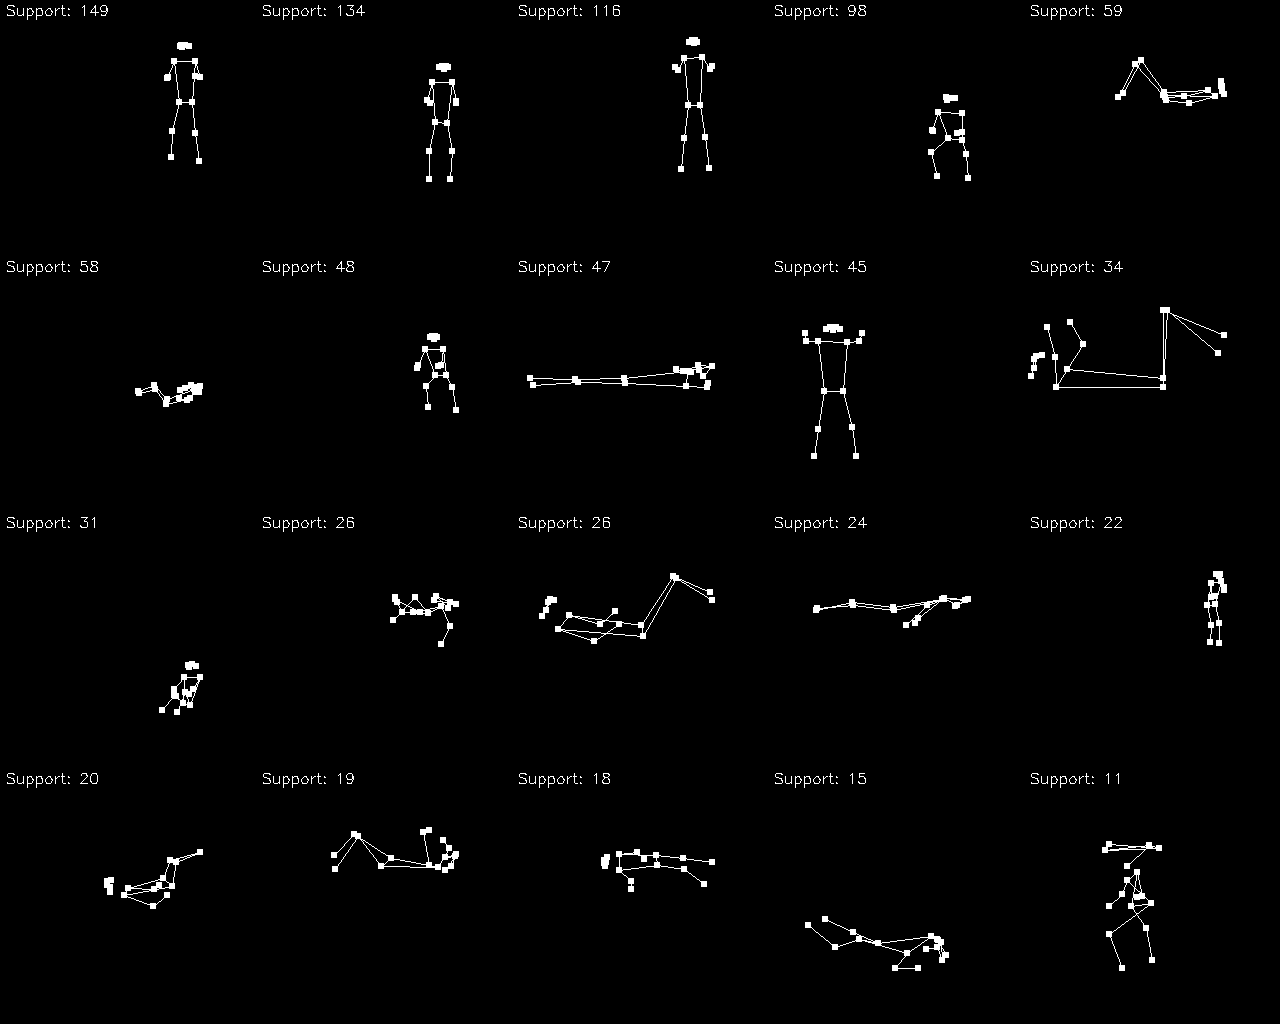

#### Edge cases clusters
As we see, the UpTrain framework identifies out-of-distribution data-points and collects the edge-cases which are sparsely present in the training dataset.
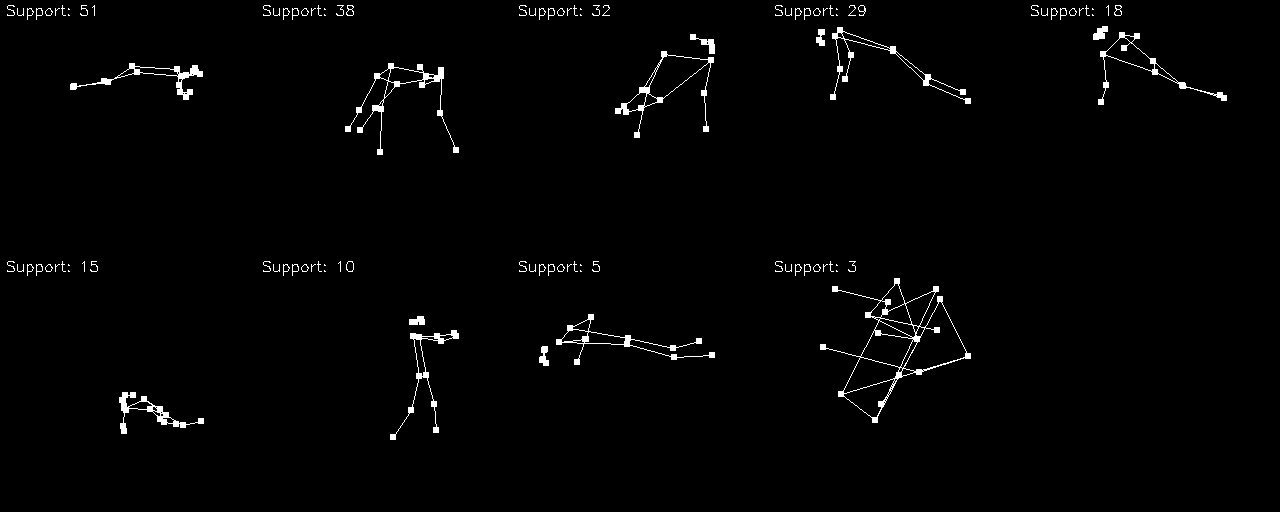


From the above plot generated while monitoring the model in production, we see that data drift occurs for many cases when the person is in a horizontal position. Specifically, cases when the person is in push-ups position are very sparse in our training dataset, causing the model predictions to go wrong for them. Let's use this insight to define a "Pushup" signal, collect all push-up related data-points and specifically retrain on them.

### Step 6: Define UpTrain signals to collect edge cases faster

Define a custom function to determine if the user is in pushup position. We do the same by
1. Determining body slope and checking if it less than 45 degrees
2. Checking if the wrist is below the shoulders
3. Checking either the person is in front orientation or wrist is directly below the shoulders

In [11]:
def pushup_signal(inputs, outputs, gts=None, extra_args={}):
    # Define signal to identify cases when the user is in the pushup position
    is_pushups = []
    for input in inputs["kps"]:
        kps = np.reshape(np.array(input), (17, 2))
        head_mean_point = np.sum(kps[0:5, 0:2], axis=0) / 5
        legs_mean_point = np.sum(kps[11:17, 0:2], axis=0) / 6
        body_slope = abs(
            (legs_mean_point[1] - head_mean_point[1])
            / max(0.1, abs(legs_mean_point[0] - head_mean_point[0]))
        )
        hands_mean_point = np.sum(kps[7:11, 0:2], axis=0) / 4
        shoulder_mean_point = np.sum(kps[5:7, 0:2], axis=0) / 2
        wrist_mean_point = np.sum(kps[9:11, 0:2], axis=0) / 2
        body_length = body_length_from_kps(kps)
        is_front_orientation = (kps[9, 0] - kps[10, 0]) > body_length
        is_pushup = (
            (body_slope < 1)
            and (hands_mean_point[1] > shoulder_mean_point[1])
            and (
                (
                    abs((wrist_mean_point[0] - shoulder_mean_point[0]) / body_length)
                    < 0.25
                )
                or is_front_orientation
            )
        )
        is_pushups.append(bool(is_pushup))
    return is_pushups

# Defining the pushup egde-case signal
pushup_edge_case = uptrain.Signal("Pushup", pushup_signal)

# Defining the model confidence edge-case signal
# That is, identify model confidence <0.9 as an edge-case
low_conf_edge_case = uptrain.Signal(uptrain.ModelSignal.BINARY_ENTROPY_CONFIDENCE, 
                is_model_signal=True) < 0.9

edge_case_signal = (pushup_edge_case | low_conf_edge_case)
edge_case_signal

In [12]:
cfg["checks"].append({
        'type': uptrain.Monitor.EDGE_CASE, 
        "signal_formulae": edge_case_signal
    })

framework = uptrain.Framework(cfg)

for i,elem in enumerate(real_world_dataset):

    # Do model prediction
    inputs = {"kps": elem[0]["kps"], "id": elem[0]["id"]}
    x_test = torch.tensor(inputs["kps"]).type(torch.float)
    test_logits = model(x_test).squeeze() 
    preds = torch.round(torch.sigmoid(test_logits)).detach().numpy()

    # Log model inputs and outputs to the uptrain Framework to monitor data drift
    idens = framework.log(inputs=inputs, outputs=preds)
    time.sleep(0.01)

    # Retrain only once
    if framework.version > 1:
        break

Deleting the folder:  uptrain_smart_data
Deleting the folder:  uptrain_logs
51 edge cases identified out of 944 total samples
101 edge cases identified out of 1824 total samples
152 edge cases identified out of 2800 total samples
201 edge cases identified out of 3648 total samples

Kicking off re-training
Creating retraining dataset: uptrain_smart_data/1/training_dataset.json  by merging  data/training_data.json  and collected edge cases.

Model retraining done...

Generating comparison report...
Evaluating model: version_0  on  15731  data-points
Evaluating model: version_1  on  15731  data-points
---------------------------------------------
---------------------------------------------
Old model accuracy:  0.9116394380522536
Retrained model accuracy (ie 201 smartly collected data-points added):  0.9779416438878648
---------------------------------------------
---------------------------------------------


As we see, by expliciting defining a signal to collect pushup cases, we are able to improve the model's performance from 91% to 99%, but much faster, i.e. after 3,650 samples (instead of 23,000 samples). This is how UpTrain can be used to get insights into the model failure cases as well as conveniently define custom rules to collect similar data-points and retrain the model upon them to improve its performance.

## Do more with UpTrain

Apart from data drift, UpTrain has many other features such as 
1. Checking for edge-cases and collecting them for automated retraining
2. Verifying data integrity, 
3. Monitoring model performance and accuracy of predictions, etc. 

To dig deeper into it, we recommend you checkout the other examples in the folder "deepdive_examples".